#  Статистика

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(42)

In [99]:
kol_dict = get_kolmagorov_values()
betta_tb = confidence_interval()
amount_of_intervals = 50
betta = 0.8
step = 1

In [6]:
def math_exp(x):
    return sum(x)/len(x)

In [7]:
def variance(x):
    return (sum([i**2 for i in x])/len(x) - math_exp(x)**2)/(len(x)-1)*len(x)

In [103]:
def examine_set(set_name):
    print(f"Set:{set_name}\n")
    with open(set_name, 'r') as f:
        x = [float(i) for i in f.readline().split(',')]
        x.sort()
        
        M = math_exp(x)
        D = variance(x)
        print("Math Expectation - ", M, " Unbiased Variance - ", D)
        print("Histogramm of experimental data")
        plot_histogramm(x)
        
        xx, probArr = equal_length_inter(x, step)
        F = probArr.copy()
        for i in range(1, len(xx)):
            F[i] += F[i - 1]
    
        print("Uniform")
        # calculate a and b using M = (a+b)/2 D=(b-a)**2/2
        a = M - (3 * D ** 0.5)
        b = M + ((3 * D ** 0.5))
        plot_uniform(a, b, len(x))
        check_uniform(x, a, b, xx, F)
        
        print("Exponential")
        plot_exponential(M, len(x))
        # M = 1/lambda
        check_exponential(x, 1/M, xx, F)
        
        print("Normal")
        plot_normal(M, D ** 0.5, len(x))
        check_normal(x, M, D ** 0.5, xx, F)
        
        print("Geometric")
        p = 1/M # Biased geom: M=1/p
        plot_geometric(p, len(x))
        check_geometric(x, p, xx, F)
        
        print("Poisson")         
        plot_poisson(M, len(x))
        check_poisson(x, M, xx, F)
        # M = lambda
        
        print("Binomial")
        p = M/len(x) # M = np
        plot_binomial(p, len(x))
        check_binomial(x, p, len(x), xx, F)
        
        print(f"Confident interval for Math Expression: b={betta} - {math_exp_conf_interval(betta, M, D, len(x))}")
        print(f"Confident interval for Variance: b={betta} - {variance_conf_interval(x, M, D, betta)}")

### Построение графиков различных законов распределения

In [101]:
def plot_histogramm(x):
    plt.hist(x, density=True, bins=1000)
    plt.ylabel('Probability')
    plt.xlabel('Data')
    plt.show()

In [10]:
def plot_uniform(a, b, n):
    uniformArr = np.random.uniform(a, b, size = n)
    
    plt.hist(uniformArr, density=True, bins=amount_of_intervals)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

In [11]:
def plot_exponential(lamb, n):
    exponentialArr = np.random.exponential(scale = lamb, size = n)
    
    plt.hist(exponentialArr, density = True, bins = amount_of_intervals)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

In [12]:
def plot_normal(m, sigm, n):
    normalArr = np.random.normal(m, sigm, n)
    
    plt.hist(normalArr, density = True, bins = amount_of_intervals)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

In [13]:
def plot_geometric(P, n):
    geometricArr = np.random.geometric(p = P, size = n)
    geometricArr.sort()
    
    plt.hist(geometricArr, density = True, bins = geometricArr[-1] - geometricArr[0] + 1)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

In [14]:
def plot_poisson(M, n):
    poissonArr = np.random.poisson(M, n)
    poissonArr.sort()
    
    plt.hist(poissonArr, density = True, bins = poissonArr[-1] - poissonArr[0] + 1)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

In [15]:
def plot_binomial(p, n):
    binomialArr = np.random.binomial(n, p, size = n)
    binomialArr.sort()
    
    plt.hist(binomialArr, density = True, bins = binomialArr[-1] - binomialArr[0] + 1)
    plt.ylabel('Probability')
    plt.xlabel('Data');
    plt.show()

### Критерий Колмагорова

In [16]:
def get_kolmagorov_values():
    with open("kolmagorov.txt", 'r') as kolmag:
        kol_dict = {}
        for line in kolmag:
            line = line.strip().split()
            kol_dict[float(line[0])] = float(line[1])
            
        return kol_dict   

In [17]:
def kolmag(lamb):
    for key in kol_dict.keys():
            if key >= lamb:
                return kol_dict[key]
            
    return 0

### Проверка распределений

In [77]:
def equal_length_inter(x, step):
    temp, i, j = {}, 0, 0
    
    for i in x:
        tmp = 0
        f = temp.get(i, 0)
        f+=1
        temp[i] = f
    
    left, right = x[0], x[0]+step
    xx = []
    prob = []
    while left < x[-1]:
        sum_int = 0
        for i in temp.keys():
            if left <= i < right:
                sum_int += temp[i]
                
        xx.append((left+right)/2)
        prob.append(sum_int/len(x))
        right+= step
        left += step
    xx.sort()
    return xx, prob

In [19]:
def check_uniform(x, a, b, xx, F):
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_uniform(xx[i], a, b)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
        
    print(f"Kolmagorov criteria:\nLambda for uniform - {delta * (len(xx) ** 0.5)}")
    print(f"Uniform probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

In [55]:
def check_geometric(x, p, xx, F):
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_geometric(xx[i], p)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
    
    print(f"Kolmagorov criteria:\nLambda for geometric - {delta * (len(xx) ** 0.5)}")
    print(f"Geometric probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

In [54]:
def check_binomial(x, p, n, xx, F):
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_binomial(xx[i], p, n)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
    
    print(f"Kolmagorov criteria:\nLambda for binomial - {delta * (len(xx) ** 0.5)}")
    print(f"Binomial probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

In [48]:
def check_exponential(x, lamb, xx, F):
    
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_exponential(xx[i], lamb)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
    
    print(f"Kolmagorov criteria:\nLambda for exponential - {delta * (len(xx) ** 0.5)}")
    print(f"Exponential probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

In [49]:
def check_normal(x, m, sigm, xx, F):
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_normal(xx[i], m, sigm)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
        
    print(f"Kolmagorov criteria:\nLambda for normal - {delta * (len(xx) ** 0.5)}")
    print(f"Normal probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

In [50]:
def check_poisson(x, lamb, xx, F):
    delta = 0
    for i in range(0,len(xx)):
        f_theory = F_poisson(xx[i], lamb)
        a = abs(F[i] - f_theory)
        delta = max(delta, a)
        i += 1
    
    print(f"Kolmagorov criteria:\nLambda for poisson - {delta * (len(xx) ** 0.5)}")
    print(f"Poisson probability - {kolmag(delta * (len(xx) ** 0.5))}\n")

### Рассчет фyнкций рапределения для типовых законов

In [25]:
def F_uniform(x, a, b):
    if x < a:
        return 0
    
    elif x > b:
        return 1
    
    else:
        return (x-a)/(b-a)

In [26]:
def F_exponential(x, lamb):
    if x <= 0:
        return 0
    
    else:
        return 1 - math.exp(-1*x*lamb)

In [27]:
def F_normal(x, m, sigm):
    return 0.5 + 0.5 * math.erf((x-m)/sigm)

In [28]:
def F_geometric(x, p):
    return 1 - (1 - p) ** x

In [29]:
def F_binomial(x, p, n):
    F_sum = 0
    for i in range(0, int(x)):
        F_sum += p**i * (1-p)**(n-i) * math.comb(n, i)
        
    return F_sum

In [30]:
def F_poisson(x, lamb):
    return lamb ** x * math.exp(-lamb) / math.factorial(abs(int(x)))

### Рассчет доверительного интервала

In [31]:
def confidence_interval():
    with open("trust_betta.txt", 'r') as f:
        betta_tb = {}
        
        for line in f:
            line = line.strip().split()
            betta_tb[float(line[0])] = float(line[1])
            
        return betta_tb

In [32]:
def calculate_confidence_interval(betta):
    for bet in betta_tb.keys():
            if bet >= betta:
                return betta_tb[bet]
            
    return 0

In [33]:
def math_exp_conf_interval(betta, M, D, n):
    t = calculate_confidence_interval(betta)
    return (M-t*(D/n)**0.5,M+t*(D/n)**0.5)

In [34]:
def centr_moment4(x):
    M = math_exp(x)
    return sum([(i-M)**4 for i in x])/len(x)

In [35]:
def variance_conf_interval(x, M, D, betta):
    centr_mom4 = centr_moment4(x)
    n = len(x)
    t = calculate_confidence_interval(betta)
    sigm = math.sqrt(centr_mom4/n - (n-3)/(n*(n-1))*D**2) 
    
    return (D-t*sigm,D+t*sigm)

Set:set_1.csv

Math Expectation -  3.44078  Unbiased Variance -  10.048293474534745
Histogramm of experimental data


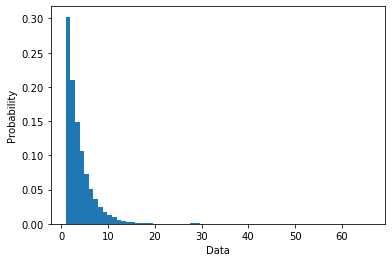

Uniform


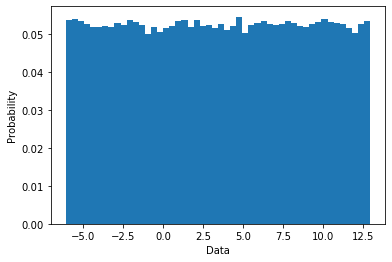

Kolmagorov criteria:
Lambda for uniform - 1.0721199954062504
Uniform probability - 0.178

Exponential


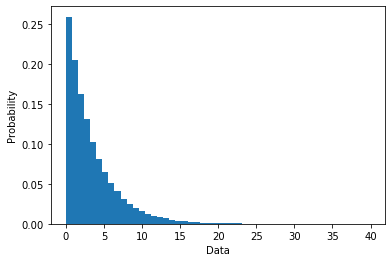

Kolmagorov criteria:
Lambda for exponential - 0.6234324820822734
Exponential probability - 0.711

Normal


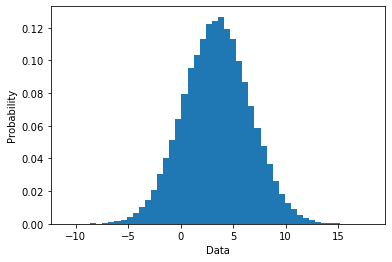

Kolmagorov criteria:
Lambda for normal - 1.0474931347073049
Normal probability - 0.178

Geometric


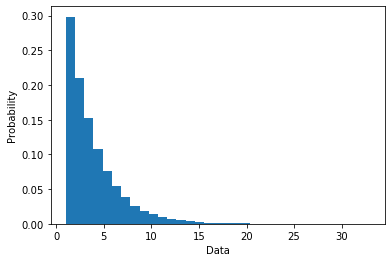

p_value: 0.0
Kolmagorov criteria:
Lambda for geometric - 0.4212543760987397
Geometric probability - 0.964

Poisson


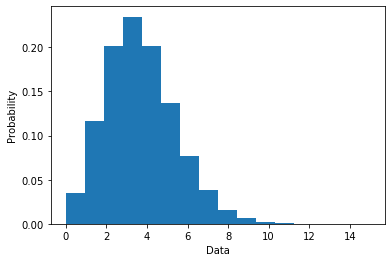

Kolmagorov criteria:
Lambda for poisson - 3.123962056283655
Poisson probability - 0

Binomial


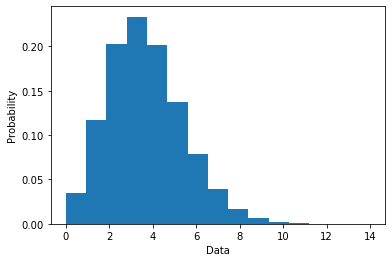

p_value: 0.005249820683786877
Kolmagorov criteria:
Lambda for binomial - 1.639855795595131
Binomial probability - 0.006

Confident interval for Math Expression: b=0.8 - (3.427929081167309, 3.4536309188326912)
Confident interval for Variance: b=0.8 - (9.858056878022847, 10.238530071046643)


In [53]:
examine_set("set_1.csv")

Set:set_2.csv

Math Expectation -  16.243283213799923  Unbiased Variance -  10928.497477401066
Histogramm of experimental data


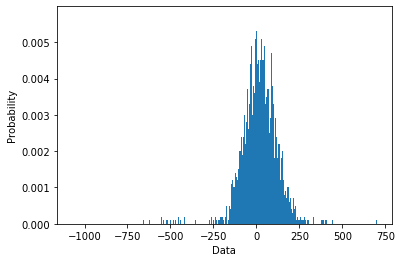

Uniform


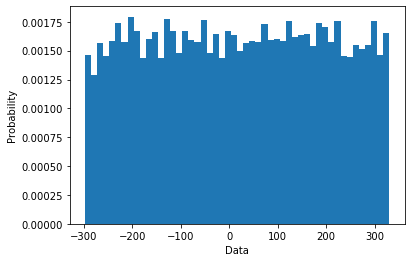

Kolmagorov criteria:
Lambda for uniform - 8.00885782341156
Uniform probability - 0

Exponential


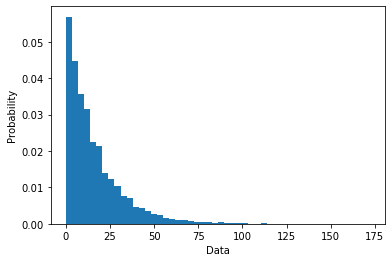

Kolmagorov criteria:
Lambda for exponential - 6.158031307163029
Exponential probability - 0

Normal


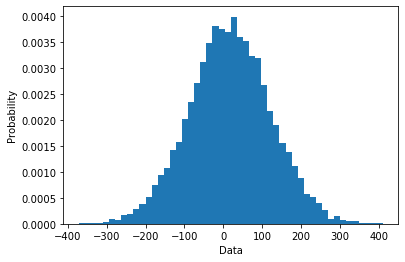

Kolmagorov criteria:
Lambda for normal - 0.6422586489772922
Normal probability - 0.711

Geometric


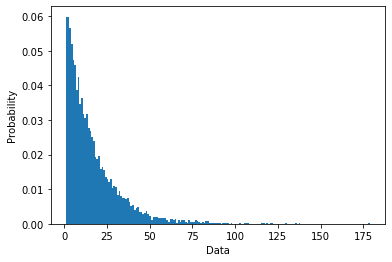

Kolmagorov criteria:
Lambda for geometric - 4.3558026244415264e+30
Geometric probability - 0

Confident interval for Math Expression: b=0.8 - (14.903087411387153, 17.583479016212696)
Confident interval for Variance: b=0.8 - (10453.79356193773, 11403.201392864403)


In [97]:
examine_set("set_2.csv")

Set:set_3.csv

Math Expectation -  0.12448845074999948  Unbiased Variance -  0.02564569147505356
Histogramm of experimental data


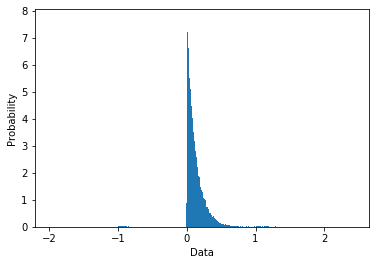

Uniform


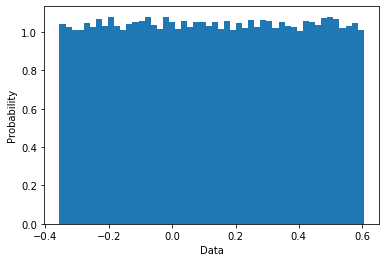

Kolmagorov criteria:
Lambda for uniform - 66.15448908549719
Uniform probability - 0

Exponential


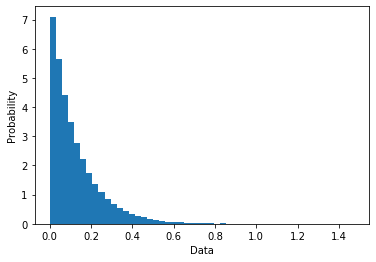

Kolmagorov criteria:
Lambda for exponential - 0.5707908074469503
Exponential probability - 0.864

Normal


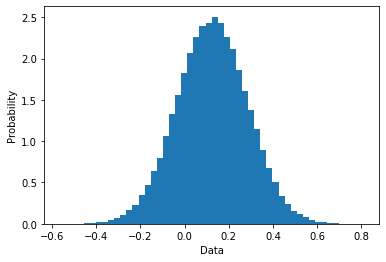

Kolmagorov criteria:
Lambda for normal - 9.293789596273822
Normal probability - 0

Confident interval for Math Expression: b=0.8 - (0.12383922575482564, 0.12513767574517332)
Confident interval for Variance: b=0.8 - (0.025173091050424458, 0.026118291899682664)


In [104]:
examine_set("set_3.csv")